In [449]:
from matplotlib import pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [494]:
data=pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [418]:
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


In [495]:
#Key words or positive_words are given below
positive_words = ['excellent','positive', 'good', 'satisfied', 'super','great', 'wonderful',
                  'awesome','best', 'fine', 'sweet', 'recommend', 'enjoyed', 'loved',
                  'favorite', 'astounding', 'recommended', 'excited', 'interested', 'proud',
                 'exciting', 'attractive', 'the best', 'awesome', 'repeat', 'watch again', 'funny'
                 'interesting', 'real quality']
             
for key in positive_words:
    truth= data.reviewText.str.contains(str(key)) 
    truth2=data['reviewText'].str.contains(str('not '+key))
    truth3=data['reviewText'].str.contains('not|dont|donot|didnot|worst|awful|bad|sucks|useless|broken|bored')
    for i in range(len(truth)):
        if ((truth.values[i] == True) & ((truth2.values[i] == True) | (truth3.values[i]==True))):
            truth.values[i]=False
    data[str(key)] = truth.astype(int)

AxesSubplot(0.125,0.125;0.62x0.755)


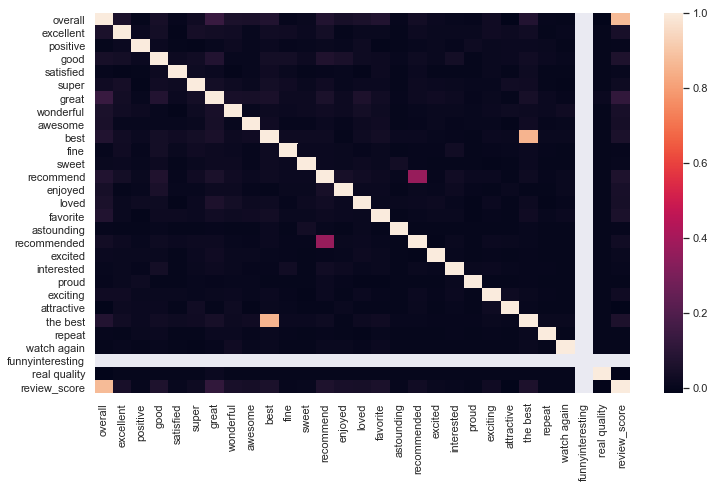

In [496]:
data.drop(['asin',  'reviewTime', 'reviewText','reviewerID', 'reviewerName', 'summary','unixReviewTime'], inplace=True, axis=1 )
data['review_score'] = np.where(data['overall'] > 3, 1, 0)

sns.set(rc={'figure.figsize':(12,7)})
print (sns.heatmap(data.corr()))


Heat map shows that most of the variables are independent of each other which is an assumption for most of the models

In [497]:
print (data.review_score.value_counts())
Y = data['review_score']
X = data.loc[:, ~(data.columns).isin(['review_score','helpful', 'overall'])]

Index(['helpful', 'overall', 'excellent', 'positive', 'good', 'satisfied',
       'super', 'great', 'wonderful', 'awesome', 'best', 'fine', 'sweet',
       'recommend', 'enjoyed', 'loved', 'favorite', 'astounding',
       'recommended', 'excited', 'interested', 'proud', 'exciting',
       'attractive', 'the best', 'repeat', 'watch again', 'funnyinteresting',
       'real quality', 'review_score'],
      dtype='object')
1    29336
0     7790
Name: review_score, dtype: int64


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [498]:
# SMOTE i.e oversampling and undersampling
smote_nc = SMOTENC(categorical_features=[0],random_state=0)
X, Y = smote_nc.fit_resample(X, Y)

In [499]:
print('Resampled dataset samples per each class\n {}'.format(Counter(Y)))

Resampled dataset samples per each class
 Counter({0: 29336, 1: 29336})


In [500]:
#Data split to Train and test
global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

In [501]:
def model(mod):
    model_object=mod
    model_object.fit(X_train, y_train)
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    pos_label=None
    y_pred=pd.Series(model_object.predict(X_test))
    
    #Plotting the ROC-AUC curve   
    if ((len(np.unique(y_test)) > 2)):
        pos_label=2
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic')
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [ ]:
### Naive Bayes Classifier

Accuracy: 0.60 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 35.476901% 
The specificity i.e true negatives is 84.932075% 
The Type I error i.e. false negatives is 64.523099% 
The Type II error i.e. false positives is 15.067925% 


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

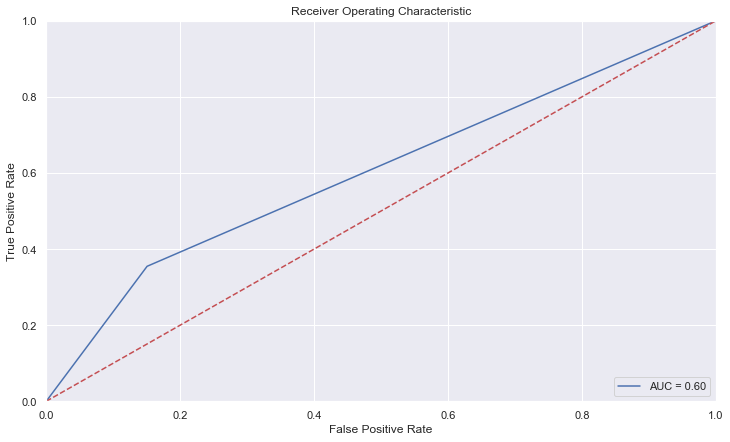

In [492]:
model(BernoulliNB())

In [ ]:
### kNN Classifier

Accuracy: 0.60 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 32.534211% 
The specificity i.e true negatives is 86.860935% 
The Type I error i.e. false negatives is 67.465789% 
The Type II error i.e. false positives is 13.139065% 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

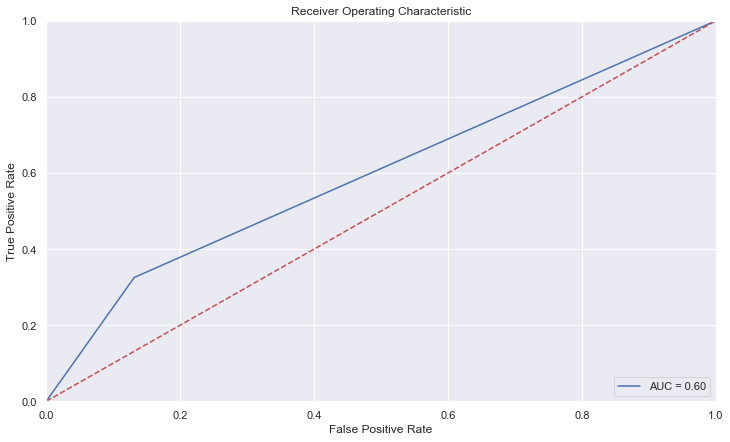

In [502]:
model(neighbors.KNeighborsClassifier(n_neighbors=10))

In [ ]:
### Logistic Regression

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Accuracy: 0.60 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 34.427410% 
The specificity i.e true negatives is 85.865395% 
The Type I error i.e. false negatives is 65.572590% 
The Type II error i.e. false positives is 14.134605% 


C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

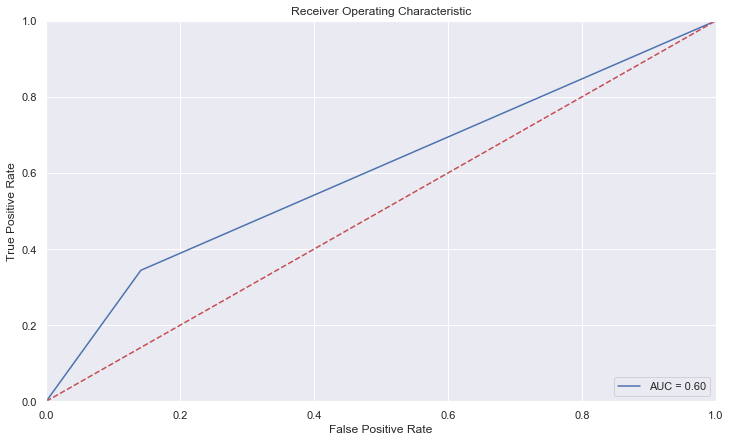

In [503]:
model(LogisticRegression(C=1e9))

In [ ]:
### Random Forest Classifier

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.60 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 34.406832% 
The specificity i.e true negatives is 86.020948% 
The Type I error i.e. false negatives is 65.593168% 
The Type II error i.e. false positives is 13.979052% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

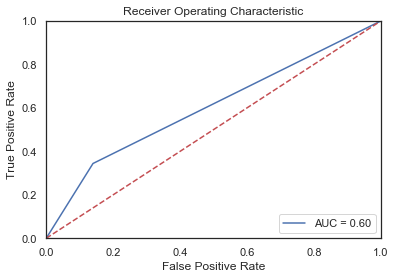

In [457]:
model(ensemble.RandomForestClassifier())

In [ ]:
### Gradient Boost Classifier

Accuracy: 0.61 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 35.312275% 
The specificity i.e true negatives is 86.311314% 
The Type I error i.e. false negatives is 64.687725% 
The Type II error i.e. false positives is 13.688686% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

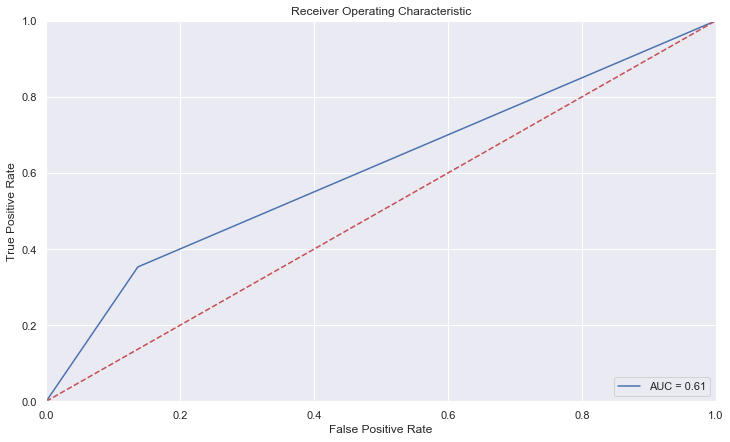

In [505]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Accuracy: 0.59 (+/- 0.02)

[0 1]
[0 1]
The sensitivity i.e true positives is 34.314230% 
The specificity i.e true negatives is 85.896505% 
The Type I error i.e. false negatives is 65.685770% 
The Type II error i.e. false positives is 14.103495% 


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

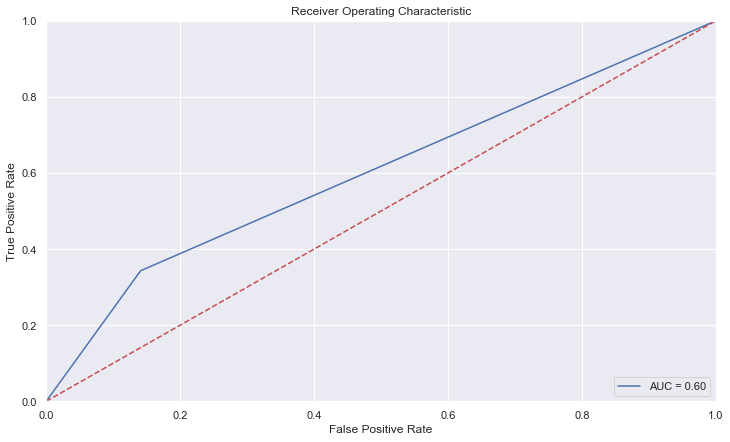

In [506]:
model(SVC())

The Gradient Boost Classifer gives the best AUC of 0.61 with 61 percent accuracy and also low errors compared to other models.

#### Compariring if the same model will be applicable to other categories of review datasets
The review datasets are so differnt that it may not be applicable to other review datasets

In [507]:
data=pd.read_json('Baby_5.json', lines=True)
#Key words or positive_words are given below
positive_words = ['excellent','positive', 'good', 'satisfied', 'super','great', 'wonderful',
                  'awesome','best', 'fine', 'sweet', 'recommend', 'enjoyed', 'loved',
                  'favorite', 'astounding', 'recommended', 'excited', 'interested', 'proud',
                 'exciting', 'attractive', 'the best', 'awesome', 'repeat', 'watch again', 'funny'
                 'interesting', 'real quality']
             
for key in positive_words:
    truth= data.reviewText.str.contains(str(key)) 
    truth2=data['reviewText'].str.contains(str('not '+key))
    truth3=data['reviewText'].str.contains('not|dont|donot|didnot|worst|awful|bad|sucks|useless|broken|bored')
    for i in range(len(truth)):
        if ((truth.values[i] == True) & ((truth2.values[i] == True) | (truth3.values[i]==True))):
            truth.values[i]=False
    data[str(key)] = truth.astype(int)
data['review_score'] = np.where(data['overall'] > 3, 1, 0)
data.drop(['asin',  'reviewTime', 'reviewText','reviewerID', 'reviewerName', 'summary','unixReviewTime'], inplace=True, axis=1 )
print (data.review_score.value_counts())
Y = data['review_score']
X = data.loc[:, ~(data.columns).isin(['review_score','helpful', 'overall'])]

1    126525
0     34267
Name: review_score, dtype: int64


In [512]:

# SMOTE i.e oversampling and undersampling
smote_nc = SMOTENC(categorical_features=[0],random_state=0)
X, Y = smote_nc.fit_resample(X, Y)

#Data split to Train and test
global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

### Grdient Boost Classfier

Accuracy: 0.59 (+/- 0.01)

[0 1]
[0 1]
The sensitivity i.e true positives is 28.642439% 
The specificity i.e true negatives is 90.316201% 
The Type I error i.e. false negatives is 71.357561% 
The Type II error i.e. false positives is 9.683799% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

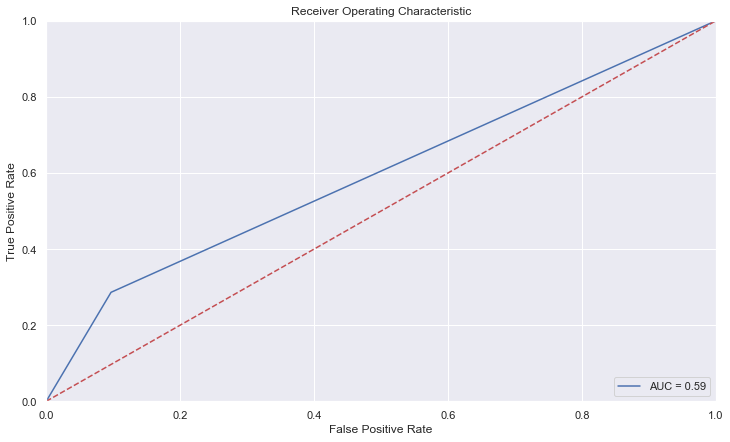

In [513]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

Shows that the model is not wildely applicable since the algorithm needs to be modified to NLP/Word or sentence embedding to generalize more.